In [1]:
# !pip install easyocr
# !pip uninstall ultralytics
# !pip install fuzzywuzzy
import ultralytics
print(ultralytics.__version__)

8.3.116


In [2]:
# import shutil

# # Replace with your folder path
# folder_path = "/content/predictions"

# # Delete the folder and all its contents
# shutil.rmtree(folder_path)


In [3]:
# import zipfile
# import os

# # Define the path for the zip file and the target extraction directory
# zip_path = '/content/test.zip'
# extract_path = '/content/'

# # Create the directory if it doesn't exist
# os.makedirs(extract_path, exist_ok=True)

# # Unzip the file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print(f"✅ Dataset unzipped to: {os.path.abspath(extract_path)}")


In [4]:
import os
import re
import cv2
import json
import torch
import easyocr
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from tensorflow.keras.models import load_model
from transformers import TrOCRProcessor, VisionEncoderDecoderModel


/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## after fine-tunnig YOLOv8 model we are going to extract text using the bounding boxes predicted

## loading fine tuned model and creating the class names to be predicted as bounding box

In [5]:
import torch
from ultralytics import YOLO

# Manually force full loading (not weights_only)
#model = torch.load("/content/runs/detect/DGX_Model/weights/best.pt", weights_only=False)

# Now load as usual
model = YOLO("/content/runs/detect/DGX_Model/weights/best.pt", task="detect")


# Define class names (must match the order in data.yaml)
class_names = [
    "nom et prenom de adherent",
    "matricule cnam",
    "matricule de adherent",
    "addresse de ladherent",
    "numero cin ou passeport",
    "nom et prenom du malade",
    "date de naissance",
    "date",
    "designation",
    "honoraire",
    "id"
]

# import ultralytics
# print(ultralytics.__version__)

## Company classifcation

In [6]:
def preprocess_image(image_path):
    image = Image.open(image_path)

    gray_image = image.convert("L")

    enhancer = ImageEnhance.Sharpness(gray_image)
    sharp_image = enhancer.enhance(2.0)

    resized_image = sharp_image.resize((256, 256), Image.LANCZOS)

    enhancer = ImageEnhance.Sharpness(resized_image)
    final_image = enhancer.enhance(1.5)

    final_image_rgb = np.stack([np.array(final_image)] * 3, axis=-1)

    image_array = final_image_rgb / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    return image_array


In [7]:
def predict_new_image(model, image_path, class_names):
    image_array = preprocess_image(image_path)

    prediction = model.predict(image_array)

    predicted_index = np.argmax(prediction[0])
    predicted_class = class_names[predicted_index]
    probability = prediction[0][predicted_index]

    return predicted_class, probability


In [8]:
# Path to the new image for prediction
image_path = "/content/test/0737--8753473--20230705_page_0_1.jpg"  # Replace with the path to your new image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image at {image_path}")



In [9]:
model_classification = load_model("insurance_classifier_vgg16.h5")
company_names = ['BH', 'CNAM', 'STAR']
predicted_company ,probability =predict_new_image(model_classification , image_path, company_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step


In [10]:
print(predicted_company)
print(probability)

STAR
0.9998752


## predicting bounding boxes

## saving predictions in a folder named predictions

In [11]:
def process_and_save_detections(image_path, results, class_names, output_root="/content/predictions"):
    # Create output directory for this image inside predictions/
    os.makedirs(output_root, exist_ok=True)


    crop_counter = 1
    for result in results:
        boxes = result.boxes.xyxy  # Bounding boxes: [x_min, y_min, x_max, y_max]
        confidences = result.boxes.conf
        class_ids = result.boxes.cls

        for box, conf, cls_id in zip(boxes, confidences, class_ids):
            x1, y1, x2, y2 = map(int, box)
            class_id = int(cls_id)
            label = class_names[class_id]
            confidence = float(conf)
            print(f"Confidence is: {confidence:.2f}")
            if label not in ["designation", "date", "honoraire"]:
                if x2 > x1 and y2 > y1:
                    cropped_image = image[y1:y2, x1:x2]
                    output_filename = f"{label.replace(' ', '_')}_{crop_counter}.jpg"
                    output_path = os.path.join(output_root, output_filename)
                    cv2.imwrite(output_path, cropped_image)
                    print(f"Saved cropped region to {output_path}")
                    crop_counter += 1
#process_and_save_detections(image_path, results, class_names)


In [12]:
# for filename in os.listdir("/content/test"):
#     if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
#         image_path = os.path.join("test", filename)
#         image = cv2.imread(image_path)
results = model(image, imgsz=640, device=None)  # Use GPU (device=0); set to None for CPU
process_and_save_detections(image_path, results, class_names)




0: 640x480 2 nom et prenom de adherents, 1 matricule cnam, 1 matricule de adherent, 1 addresse de ladherent, 1 numero cin ou passeport, 1 nom et prenom du malade, 1 date de naissance, 1 date, 1 designation, 1 honoraire, 1 id, 442.5ms
Speed: 5.9ms preprocess, 442.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
Confidence is: 0.93
Confidence is: 0.90
Confidence is: 0.90
Confidence is: 0.84
Saved cropped region to /content/predictions/numero_cin_ou_passeport_1.jpg
Confidence is: 0.80
Saved cropped region to /content/predictions/nom_et_prenom_du_malade_2.jpg
Confidence is: 0.80
Saved cropped region to /content/predictions/nom_et_prenom_de_adherent_3.jpg
Confidence is: 0.80
Saved cropped region to /content/predictions/date_de_naissance_4.jpg
Confidence is: 0.78
Saved cropped region to /content/predictions/addresse_de_ladherent_5.jpg
Confidence is: 0.75
Saved cropped region to /content/predictions/matricule_de_adherent_6.jpg
Confidence is: 0.75
Saved cropped region to /

## extract text using TrOCR

In [13]:
# import os
# import cv2
# import easyocr

# def draw_ocr_boxes(image_path, lang='fr', output_dir="predictions_cropped"):
#     # Load image
#     img = cv2.imread(image_path)
#     if img is None:
#         print(f"Error: Unable to load image from {image_path}")
#         return

#     # Create EasyOCR reader
#     reader = easyocr.Reader([lang], gpu=False)

#     # Run OCR
#     results = reader.readtext(img, detail=1, paragraph=False)

#     # Create output dir
#     os.makedirs(output_dir, exist_ok=True)

#     if len(results) == 0:
#         print("No text detected.")
#         return

#     # Process all detected words and draw bounding boxes
#     filename = os.path.splitext(os.path.basename(image_path))[0]
#     for idx, (bbox, text, prob) in enumerate(results):
#         # Extract bounding box coordinates
#         (top_left, _, bottom_right, _) = bbox
#         top_left = (int(top_left[0]), int(top_left[1]))
#         bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

#         # Draw bounding box on the original image
#         cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)

#         # Add text and confidence score above the bounding box
#         label = f"{text} ({prob:.2f})"
#         cv2.putText(img, label, (top_left[0], top_left[1] - 10),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

#     # Save the annotated image
#     output_path = os.path.join(output_dir, f"{filename}_annotated.jpg")
#     cv2.imwrite(output_path, img)
#     print(f"Annotated image saved to: {output_path}")

# # # Loop through each file in the folder
# # for filename in os.listdir("predictions"):
# #     if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
# #         image_path = os.path.join("predictions", filename)
# #         draw_ocr_boxes(image_path)

In [14]:
# predictions_root = "predictions"

# # Loop through each subfolder inside 'predictions'
# for subfolder in os.listdir(predictions_root):
#     subfolder_path = os.path.join(predictions_root, subfolder)

#     # Ensure it's a folder
#     if os.path.isdir(subfolder_path):
#         subfolder_name = os.path.basename(subfolder_path)  # <- this gives you just the folder name

#         # Loop through each image file in the subfolder
#         for filename in os.listdir(subfolder_path):
#             if filename.lower().endswith((".jpg", ".jpeg", ".png")):
#                 image_path = os.path.join(subfolder_path, filename)

#                 save_dir = os.path.join("predictions_cropped", subfolder_name)
#                 os.makedirs(save_dir, exist_ok=True)

#                 # Call the function with extracted subfolder name used in save_path
#                 draw_ocr_boxes(image_path, output_dir=save_dir)


In [15]:
import os
import cv2
import easyocr
import numpy as np

def horizontal_proximity(box1, box2, proximity_thresh=40, alignment_thresh=15):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Check horizontal closeness
    if abs(x1_min - x2_max) < proximity_thresh or abs(x2_min - x1_max) < proximity_thresh:
        # Check vertical alignment (Y-center difference is small)
        y_center_1 = (y1_min + y1_max) / 2
        y_center_2 = (y2_min + y2_max) / 2
        if abs(y_center_1 - y_center_2) < alignment_thresh:
            return True
    return False


def merge_boxes(boxes):
    merged = []
    used = [False] * len(boxes)

    for i in range(len(boxes)):
        if used[i]:
            continue
        x1, y1, x2, y2 = boxes[i]
        new_box = [x1, y1, x2, y2]
        used[i] = True
        for j in range(i + 1, len(boxes)):
            if not used[j] and horizontal_proximity(new_box, boxes[j]):
                bx1, by1, bx2, by2 = boxes[j]
                new_box = [
                    min(new_box[0], bx1),
                    min(new_box[1], by1),
                    max(new_box[2], bx2),
                    max(new_box[3], by2)
                ]
                used[j] = True
        merged.append(new_box)
    return merged

def detect_and_save_all_words(image_path, lang='fr', output_dir="predictions_cropped", proximity_threshold=40,template="STAR"):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image from {image_path}")
        return

    reader = easyocr.Reader([lang], gpu=False)
    results = reader.readtext(img, detail=1, paragraph=False,min_size=10,text_threshold=0.3)

    if len(results) == 0:
        print("No text detected.")
        return

    os.makedirs(output_dir, exist_ok=True)

    filename = os.path.splitext(os.path.basename(image_path))[0]

    # Extract bounding boxes
    raw_boxes = []
    for (bbox, text, prob) in results:
        (tl, tr, br, bl) = bbox
        x_min = int(min([pt[0] for pt in bbox]))
        y_min = int(min([pt[1] for pt in bbox]))
        x_max = int(max([pt[0] for pt in bbox]))
        y_max = int(max([pt[1] for pt in bbox]))
        raw_boxes.append([x_min, y_min, x_max, y_max])

    # Merge nearby boxes
    merged_boxes = merge_boxes(raw_boxes)

    # Save merged crops
    for idx, (x1, y1, x2, y2) in enumerate(merged_boxes):
        cropped = img[y1:y2, x1:x2]
        if template in ["BH","CNAM"]:
          if cropped.shape[0] > 0 and cropped.shape[1] > 0:
              save_path = os.path.join(output_dir, f"{filename}_crop_{idx+1}.jpg")
              cv2.imwrite(save_path, cropped)
              print(f"Saved: {save_path}")
          else:
              print("Skipped empty crop.")
        else :
          if cropped.shape[0] > 40 and cropped.shape[1] > 40:
              save_path = os.path.join(output_dir, f"{filename}_crop_{idx+1}.jpg")
              cv2.imwrite(save_path, cropped)
              print(f"Saved: {save_path}")
          else:
              print("Skipped empty crop.")


In [16]:
# predictions_root = "predictions"

# # Loop through each subfolder inside 'predictions'
# for subfolder in os.listdir(predictions_root):
#     subfolder_path = os.path.join(predictions_root, subfolder)

#     # Ensure it's a folder
#     if os.path.isdir(subfolder_path):
#         subfolder_name = os.path.basename(subfolder_path)  # <- this gives you just the folder name
#         predicted_class ,probability =predict_new_image(model_classification , image_path, company_names)
#         # Loop through each image file in the subfolder
#         for filename in os.listdir(subfolder_path):
#             if filename.lower().endswith((".jpg", ".jpeg", ".png")):
#                 image_path = os.path.join(subfolder_path, filename)

#                 save_dir = os.path.join("predictions_cropped", subfolder_name)
#                 os.makedirs(save_dir, exist_ok=True)

#                 # Call the function with extracted subfolder name used in save_path
#                 detect_and_save_all_words(image_path, output_dir=save_dir)


# Loop through each file in the folder
for filename in os.listdir("/content/predictions"):
    if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
        image_path = os.path.join("predictions", filename)
        detect_and_save_all_words(image_path,template=predicted_company)



Saved: predictions_cropped/matricule_de_adherent_6_crop_1.jpg


Saved: predictions_cropped/numero_cin_ou_passeport_1_crop_1.jpg


Saved: predictions_cropped/nom_et_prenom_du_malade_2_crop_1.jpg
Saved: predictions_cropped/nom_et_prenom_du_malade_2_crop_2.jpg


Saved: predictions_cropped/id_7_crop_1.jpg


Saved: predictions_cropped/nom_et_prenom_de_adherent_9_crop_1.jpg
Skipped empty crop.


Saved: predictions_cropped/nom_et_prenom_de_adherent_3_crop_1.jpg


Skipped empty crop.
Skipped empty crop.
Skipped empty crop.


Saved: predictions_cropped/addresse_de_ladherent_5_crop_1.jpg
Saved: predictions_cropped/matricule_cnam_8_crop_1.jpg


In [17]:
adherent_name = []
matricule_cnam = []
matricule_adherent = []
adresse_adherent = []
cin_ou_passeport = []
malade_name = []
date_naissance = []
id_field = []


In [24]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
def extract_texts_from_images(predictions_folder="predictions",output_json_path=None,show_images=True):
    global adherent_name, malade_name,matricule_cnam,matricule_adherent,adresse_adherent,cin_ou_passeport,id_field,date_naissance
    # Load the TrOCR model and processor
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
    model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

    # Dictionary to store extracted text
    extracted_texts = {}

    # Iterate over all images in the predictions folder
    for image_name in os.listdir(predictions_folder):
        if not image_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue  # Skip non-image files

        image_path = os.path.join(predictions_folder, image_name)

        try:
            image = Image.open(image_path).convert("RGB")
            pixel_values = processor(images=image, return_tensors="pt").pixel_values
            generated_ids = model.generate(pixel_values)
            predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            extracted_texts[image_name] = predicted_text


            if "nom_et_prenom_de_adherent" in image_name:
                adherent_name.append(predicted_text)
            elif "matricule_cnam" in image_name:
                predicted_text = re.sub(r'[^0-9]', '', predicted_text)
                matricule_cnam.append(predicted_text)
            elif "matricule_de_adherent" in image_name:
                predicted_text = re.sub(r'[^0-9]', '', predicted_text)
                matricule_adherent.append(predicted_text)
            elif "addresse_de_ladherent" in image_name:
                adresse_adherent.append(predicted_text)
            elif "numero_cin_ou_passeport" in image_name:
                predicted_text = re.sub(r'[^0-9]', '', predicted_text)
                cin_ou_passeport.append(predicted_text)
            elif "nom_et_prenom_du_malade" in image_name:
                malade_name.append(predicted_text)
            elif "date_de_naissance" in image_name:
                predicted_text = re.sub(r'[^0-9/]', '', predicted_text)
                date_naissance.append(predicted_text)
            elif image_name.startswith("id") or "id_" in image_name:
                id_field.append(predicted_text)

            if show_images:
                plt.imshow(image)
                plt.title(predicted_text, fontsize=12)
                plt.axis('off')
                plt.show()

            print(f"Extracted text from {image_name}: {predicted_text}")

        except Exception as e:
            print(f"Error processing {image_name}: {str(e)}")
            extracted_texts[image_name] = "Error: Could not extract text"

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_

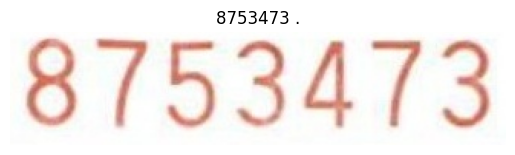

Extracted text from id_7_crop_1.jpg: 8753473 .


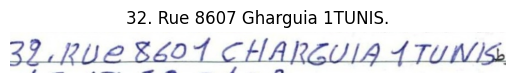

Extracted text from addresse_de_ladherent_5_crop_1.jpg: 32. Rue 8607 Gharguia 1TUNIS.


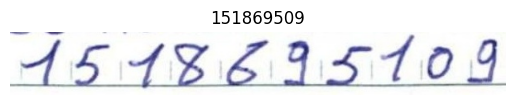

Extracted text from matricule_cnam_8_crop_1.jpg: 151869509


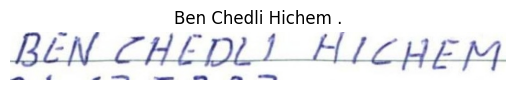

Extracted text from nom_et_prenom_de_adherent_9_crop_1.jpg: Ben Chedli Hichem .


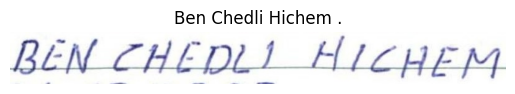

Extracted text from nom_et_prenom_de_adherent_3_crop_1.jpg: Ben Chedli Hichem .


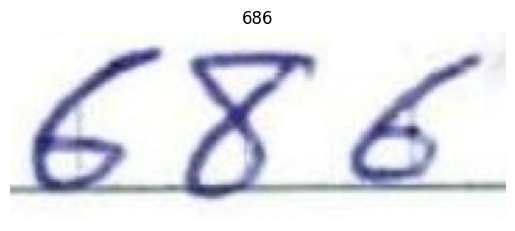

Extracted text from matricule_de_adherent_6_crop_1.jpg: 686


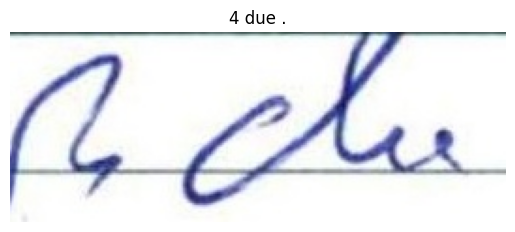

Extracted text from nom_et_prenom_du_malade_2_crop_2.jpg: 4 due .


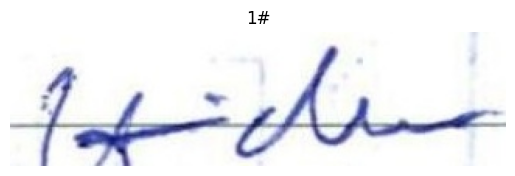

Extracted text from nom_et_prenom_du_malade_2_crop_1.jpg: 1#


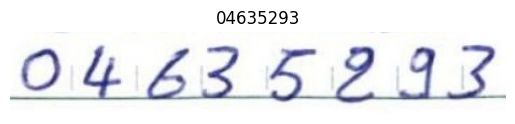

Extracted text from numero_cin_ou_passeport_1_crop_1.jpg: 04635293


In [25]:
predictions_root = "predictions_cropped"

if os.path.isdir(predictions_root):
        # Loop through each image file in the subfolder
  extract_texts_from_images(
        predictions_folder=predictions_root,
        output_json_path=None,
        show_images=True
  )




In [46]:
def match_word_to_names(word,name_list, threshold=60):
    matches = []
    for name in name_list:
        similarity = fuzz.ratio(word.lower(), name.lower())
        if similarity >= threshold:
            matches.append((name, similarity))
    return matches


In [47]:
# Load the cleaned names once
df = pd.read_csv('/content/dataset_names.csv')
name_list = df['names'].dropna().astype(str).tolist()


In [49]:
adherent_name=["Ben Chedli Hichem ."]
print(adherent_name)
print(len(adherent_name))
def clean_and_match_name(name, name_list, threshold=60):
    # Step 1: Clean the name
    if isinstance(name, list) and len(name) == 1:
        cleaned = re.sub(r'[^a-zA-Z\s]', '', name[0])
        name_parts = [word for word in cleaned.split() if word]
    else : 
        name_parts = [re.sub(r'[^a-zA-Z]', '', n) for n in name]

    # Step 2: Match each part
    if name_parts:
        for part in name_parts:
            predict = match_word_to_names(part, name_list, threshold=threshold)
            predict = sorted(predict, key=lambda x: x[1], reverse=True)

            print(f"Matches for \033[1m{part}\033[0m")
            if predict:
                for matched_name, similarity in predict:
                    print(f"\033[1m'{matched_name}'\033[0m (Similarity: {similarity}%)")
            else:
                print(f"No match for {part}")
            print("\n")

['Ben Chedli Hichem .']
1
['Ben', 'Chedli', 'Hichem']
Matches for Ben
'beena' (Similarity: 75%)
'ibn' (Similarity: 67%)
'mobeen' (Similarity: 67%)
'mubeen' (Similarity: 67%)
'ban' (Similarity: 67%)
'jabeen' (Similarity: 67%)
'lubena' (Similarity: 67%)
'mobena' (Similarity: 67%)
'sabeen' (Similarity: 67%)
'ambreen' (Similarity: 60%)
'beenish' (Similarity: 60%)
'benazir' (Similarity: 60%)
'benzair' (Similarity: 60%)
'sabreen' (Similarity: 60%)


Matches for Chedli
'chandni' (Similarity: 62%)
'adli' (Similarity: 60%)
'hadi' (Similarity: 60%)


Matches for Hichem
'hisham' (Similarity: 67%)
'haitham' (Similarity: 62%)
'shaheem' (Similarity: 62%)
'shihaam' (Similarity: 62%)
'irem' (Similarity: 60%)




In [22]:
clean_and_match_name(adherent_name, name_list, threshold=70)
clean_and_match_name(malade_name, name_list, threshold=70)
